In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

## Load & Explore :

In [2]:
df=pd.read_csv("C:\\Users\\user\\Downloads\\myntra_dataset_ByScraping.csv")

In [3]:
df.head()

,brand_name,pants_description,price,MRP,discount_percent,ratings,number_of_ratings
0,WROGN,Men Loose Fit Cotton Jeans,1374.0,2499.0,0.45,4.2,57.0
1,Flying Machine,Men Slim Fit Jeans,1829.0,2999.0,0.39,4.6,5.0
2,Roadster,Men Pure Cotton Jeans,974.0,2499.0,0.61,3.6,1100.0
3,Bene Kleed,Relaxed Fit Denim Jeans,873.0,2299.0,0.62,4.0,4800.0
4,Levis,Men 511 Slim Fit Jeans,1478.0,2899.0,0.49,4.3,264.0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52120 entries, 0 to 52119
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   brand_name         52120 non-null  object 
 1   pants_description  52120 non-null  object 
 2   price              52120 non-null  float64
 3   MRP                52120 non-null  float64
 4   discount_percent   52120 non-null  float64
 5   ratings            52120 non-null  float64
 6   number_of_ratings  52120 non-null  float64
dtypes: float64(5), object(2)
memory usage: 2.8+ MB


In [5]:
df.describe()

,price,MRP,discount_percent,ratings,number_of_ratings
count,52120.000000,52120.000000,52120.000000,52120.000000,52120.000000
mean,1594.515445,3180.398438,1.648256,3.997794,91.568937
std,1495.972325,2201.883218,4.687529,0.420404,433.918513
min,337.000000,499.000000,0.020000,1.000000,5.000000
25%,989.000000,2499.000000,0.400000,3.800000,16.000000
50%,1439.000000,2999.000000,0.500000,4.000000,35.000000
75%,1829.000000,3499.000000,0.630000,4.200000,74.000000
max,54000.000000,72000.000000,64.000000,5.000000,30700.000000


## Cleaning : Missing & Inconsistent Data 

-  Identify columns with missing values :

In [6]:
df.isnull().sum()

brand_name           0
pants_description    0
price                0
MRP                  0
discount_percent     0
ratings              0
number_of_ratings    0
dtype: int64

- Ensure numeric columns are numeric cast price, MRP, discount_percent, ratings, number_of_ratings to numeric (coerce errors). 

In [7]:
df["price"]=df["price"].astype('int')
df["MRP"]=df["MRP"].astype('int')
df["number_of_ratings"]=df["number_of_ratings"].astype('int')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52120 entries, 0 to 52119
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   brand_name         52120 non-null  object 
 1   pants_description  52120 non-null  object 
 2   price              52120 non-null  int64  
 3   MRP                52120 non-null  int64  
 4   discount_percent   52120 non-null  float64
 5   ratings            52120 non-null  float64
 6   number_of_ratings  52120 non-null  int64  
dtypes: float64(2), int64(3), object(2)
memory usage: 2.8+ MB


- Handle missing numeric data: fill ratings with its median and number_of_ratings with 0. Drop rows where price or MRP is missing.

In [8]:
df['ratings']=df['ratings'].fillna(df['ratings'].median())
df['number_of_ratings']=df['number_of_ratings'].fillna(0)
df=df.dropna(subset=['price','MRP'])

- Fix inconsistencies: ensure price and MRP are positive; clip negatives to NaN then drop. Ensure discount_percent is between 0 and 1 (clip),
- then recompute a clean net_discount = (MRP - price) / MRP.

In [9]:
cols=['price','MRP']
for i in cols:
    df.loc[df[i] <0 ,i]=np.nan
    df=df.dropna(subset=['price','MRP'])

df['discount_percent']=df['discount_percent'].clip(lower=0,upper=1)
df['net_discount']=(df['MRP']-df['price'])/df['MRP']             

## Deriving New Columns :

- Create discount_amount = MRP - price.

In [10]:
df['discount_amount']=df['MRP']-df["price"]
df.head(3)

,brand_name,pants_description,price,MRP,discount_percent,ratings,number_of_ratings,net_discount,discount_amount
0,WROGN,Men Loose Fit Cotton Jeans,1374.0,2499.0,0.45,4.2,57,0.450180,1125.0
1,Flying Machine,Men Slim Fit Jeans,1829.0,2999.0,0.39,4.6,5,0.390130,1170.0
2,Roadster,Men Pure Cotton Jeans,974.0,2499.0,0.61,3.6,1100,0.610244,1525.0


- Bucket ratings into categories with pd.cut: ['low', 'mid', 'high'] using bins [0,3.5,4.2,5]. Store in rating_band.

In [11]:
bins=[0,3.5,4.2,5]
labels=['low','mid','high']
df['rating_band']=pd.cut(df['ratings'],bins=bins,labels=labels)
df.head(3)

,brand_name,pants_description,price,MRP,discount_percent,ratings,number_of_ratings,net_discount,discount_amount,rating_band
0,WROGN,Men Loose Fit Cotton Jeans,1374.0,2499.0,0.45,4.2,57,0.450180,1125.0,mid
1,Flying Machine,Men Slim Fit Jeans,1829.0,2999.0,0.39,4.6,5,0.390130,1170.0,high
2,Roadster,Men Pure Cotton Jeans,974.0,2499.0,0.61,3.6,1100,0.610244,1525.0,mid


- Create review_band from number_of_ratings using pd.qcut into 4 quantiles (Q1..Q4).

In [12]:
labels=['Q1','Q2','Q3','Q4']
df['review_band']=pd.qcut(df['number_of_ratings'],4,labels=labels)
df.head()

,brand_name,pants_description,price,MRP,discount_percent,ratings,number_of_ratings,net_discount,discount_amount,rating_band,review_band
0,WROGN,Men Loose Fit Cotton Jeans,1374.0,2499.0,0.45,4.2,57,0.450180,1125.0,mid,Q3
1,Flying Machine,Men Slim Fit Jeans,1829.0,2999.0,0.39,4.6,5,0.390130,1170.0,high,Q1
2,Roadster,Men Pure Cotton Jeans,974.0,2499.0,0.61,3.6,1100,0.610244,1525.0,mid,Q4
3,Bene Kleed,Relaxed Fit Denim Jeans,873.0,2299.0,0.62,4.0,4800,0.620270,1426.0,mid,Q4
4,Levis,Men 511 Slim Fit Jeans,1478.0,2899.0,0.49,4.3,264,0.490169,1421.0,high,Q4


- Create a simple value_score = ratings * (1 + net_discount).

In [13]:
df['value_score']=df['ratings']*(1+df['net_discount'])
df.head()

,brand_name,pants_description,price,MRP,discount_percent,ratings,number_of_ratings,net_discount,discount_amount,rating_band,review_band,value_score
0,WROGN,Men Loose Fit Cotton Jeans,1374.0,2499.0,0.45,4.2,57,0.450180,1125.0,mid,Q3,6.090756
1,Flying Machine,Men Slim Fit Jeans,1829.0,2999.0,0.39,4.6,5,0.390130,1170.0,high,Q1,6.394598
2,Roadster,Men Pure Cotton Jeans,974.0,2499.0,0.61,3.6,1100,0.610244,1525.0,mid,Q4,5.796879
3,Bene Kleed,Relaxed Fit Denim Jeans,873.0,2299.0,0.62,4.0,4800,0.620270,1426.0,mid,Q4,6.481079
4,Levis,Men 511 Slim Fit Jeans,1478.0,2899.0,0.49,4.3,264,0.490169,1421.0,high,Q4,6.407727


## GroupBy, Aggregations, Multi-index

- Group by brand_name and compute mean price, mean ratings, and count of products.

In [14]:
df.groupby('brand_name').agg(mean_price=('price','mean'),
                             mean_ratings=('ratings','mean'),
                             count_products=('brand_name','count'))

,mean_price,mean_ratings,count_products
brand_name,,,
7 For All Mankind,16223.538462,4.230769,13
7OUNCE,1329.000000,4.300000,3
AD By Arvind,1777.455285,3.993496,123
ADBUCKS,1099.000000,3.912500,8
ADIDAS Originals,6399.000000,4.100000,2
...,...,...,...
mode de base,2975.923077,4.223077,13
nostrum,1700.818182,4.009091,11
prochain,919.000000,4.150000,2


- Use agg() for multi-aggregation on price and ratings grouped by brand_name (mean, median, std).

In [15]:
df.groupby('brand_name').agg(mean_price=('price','mean'),
                             median_price=('price','median'),
                             std_price=('price','std'))
                                         

,mean_price,median_price,std_price
brand_name,,,
7 For All Mankind,16223.538462,17700.0,5691.722654
7OUNCE,1329.000000,1349.0,62.449980
AD By Arvind,1777.455285,1674.0,603.750006
ADBUCKS,1099.000000,1099.0,106.904497
ADIDAS Originals,6399.000000,6399.0,6222.539674
...,...,...,...
mode de base,2975.923077,2999.0,258.694950
nostrum,1700.818182,1549.0,721.960223
prochain,919.000000,919.0,0.000000


 - Create a multi-index groupby by brand_name and rating_band, aggregating price mean and product count. Display the first 10 rows.

In [16]:
df.groupby(['brand_name','rating_band'],observed=False).agg(price_mean=('price','mean'),
                                           product_count=('brand_name','count')).head(10)

price_mean  product_count
brand_name        rating_band                             
7 For All Mankind low                   NaN              0
                  mid          16169.750000              8
                  high         16309.600000              5
7OUNCE            low                   NaN              0
                  mid                   NaN              0
                  high          1329.000000              3
AD By Arvind      low           1410.571429              7
                  mid           1827.010204             98
                  high          1650.333333             18
ADBUCKS           low                   NaN              0

## Pivot Tables

- Build a pivot table with index=brand_name, columns=rating_band, values=price, aggfunc='mean'.

In [17]:
pd.pivot_table(df,
               index='brand_name',
               columns='rating_band',
               values='price',
               aggfunc='mean',
              observed = False)

rating_band,low,mid,high
brand_name,,,
7 For All Mankind,NaN,16169.750000,16309.600000
7OUNCE,NaN,NaN,1329.000000
AD By Arvind,1410.571429,1827.010204,1650.333333
ADBUCKS,NaN,1113.285714,999.000000
ADIDAS Originals,NaN,6399.000000,NaN
...,...,...,...
mode de base,2799.000000,2865.666667,3115.666667
nostrum,805.000000,1864.000000,1618.666667
prochain,NaN,919.000000,919.000000


- Create a pivot table of product counts by brand_name (rows) and review_band (columns)

In [18]:
pd.pivot_table(df,
               index='brand_name',
               columns='review_band',
               values="MRP",
               aggfunc="count",
              observed = False)

review_band,Q1,Q2,Q3,Q4
brand_name,,,,
7 For All Mankind,4,5,2,2
7OUNCE,0,0,0,3
AD By Arvind,32,31,36,24
ADBUCKS,3,2,0,3
ADIDAS Originals,1,1,0,0
...,...,...,...,...
mode de base,9,1,2,1
nostrum,3,3,1,4
prochain,0,0,1,1


## Merging / Joining DataFrames

- Create a small mapping DataFrame brand_segment with two segments: mark the top 5 brands by product count as 'Top', others as 'Other'. 
- Merge it back to df on brand_name.

In [19]:
Top5_Brand=df['brand_name'].value_counts().head(5).index.tolist()
brand_segment=pd.DataFrame({
    'brand_name': df['brand_name'].unique()})
brand_segment['brand_segment']=brand_segment['brand_name'].apply(
                    lambda x : 'Top' if x in Top5_Brand else 'Other')
df=df.merge(brand_segment,on ='brand_name',how = 'left')
df.head()

,brand_name,pants_description,price,MRP,discount_percent,ratings,number_of_ratings,net_discount,discount_amount,rating_band,review_band,value_score,brand_segment
0,WROGN,Men Loose Fit Cotton Jeans,1374.0,2499.0,0.45,4.2,57,0.450180,1125.0,mid,Q3,6.090756,Top
1,Flying Machine,Men Slim Fit Jeans,1829.0,2999.0,0.39,4.6,5,0.390130,1170.0,high,Q1,6.394598,Top
2,Roadster,Men Pure Cotton Jeans,974.0,2499.0,0.61,3.6,1100,0.610244,1525.0,mid,Q4,5.796879,Top
3,Bene Kleed,Relaxed Fit Denim Jeans,873.0,2299.0,0.62,4.0,4800,0.620270,1426.0,mid,Q4,6.481079,Other
4,Levis,Men 511 Slim Fit Jeans,1478.0,2899.0,0.49,4.3,264,0.490169,1421.0,high,Q4,6.407727,Other


- Compute a summary DataFrame seg_summary = mean price and mean ratings by segment, and sort by mean price desc.

In [20]:
seg_summary=df.groupby ('brand_segment').agg({
       'price':'mean',
       'ratings':'mean'}).reset_index()
seg_summary = seg_summary.sort_values('price', ascending=False)
print(seg_summary)

  brand_segment        price   ratings
0         Other  1659.119321  3.980474
1           Top  1494.256708  4.024672


## Filtering & Sorting 

- Filter products with value_score >= 4.0 and net_discount >= 0.3. Sort by value_score desc; show top 10.

In [21]:
df[(df['value_score']>=4)&(df['net_discount']>=0.3)].sort_values('value_score',ascending=False).head(10)

,brand_name,pants_description,price,MRP,discount_percent,ratings,number_of_ratings,net_discount,discount_amount,rating_band,review_band,value_score,brand_segment
44505,Bene Kleed,Men Highly Distressed Jeans,479.0,2999.0,0.84,5.0,5,0.840280,2520.0,high,Q1,9.201400,Other
44486,Bene Kleed,Men Highly Distressed Jeans,479.0,2999.0,0.84,5.0,5,0.840280,2520.0,high,Q1,9.201400,Other
11727,VYNTIQ,Baggy Mid-Rise Heavy Fade Jean,499.0,2999.0,1.00,5.0,7,0.833611,2500.0,high,Q1,9.168056,Other
14333,WROGN,Men Slim Fit Mid-Rise Jeans,499.0,2999.0,1.00,5.0,5,0.833611,2500.0,high,Q1,9.168056,Top
14334,United Colors of Benetton,Men Slim Fit Mid-Rise Jeans,499.0,2999.0,1.00,5.0,5,0.833611,2500.0,high,Q1,9.168056,Top
14332,ANGERHOOD,Men Mid-Rise Jeans,499.0,2999.0,1.00,5.0,5,0.833611,2500.0,high,Q1,9.168056,Other
13573,DENIMLOOK,Men Jeans,599.0,2999.0,1.00,5.0,6,0.800267,2400.0,high,Q1,9.001334,Other
2185,Bene Kleed,Men Relaxed Fit Jeans,479.0,2999.0,0.84,4.8,11,0.840280,2520.0,high,Q1,8.833344,Other
3353,Thomas Scott,Men Slim Fit Mid-Rise Jeans,1249.0,4999.0,0.75,5.0,5,0.750150,3750.0,high,Q1,8.750750,Other
39388,FREAKINS,Men Baggy Fit Jeans,1199.0,6099.0,1.00,4.8,6,0.803410,4900.0,high,Q1,8.656370,Other


## Visualizing with Pandas .plot() (line, bar, hist, pie); Plotting from groupby

- From gb_brand (mean_price/count), plot a bar chart of the top 10 brands by count_items. Add labels and title.

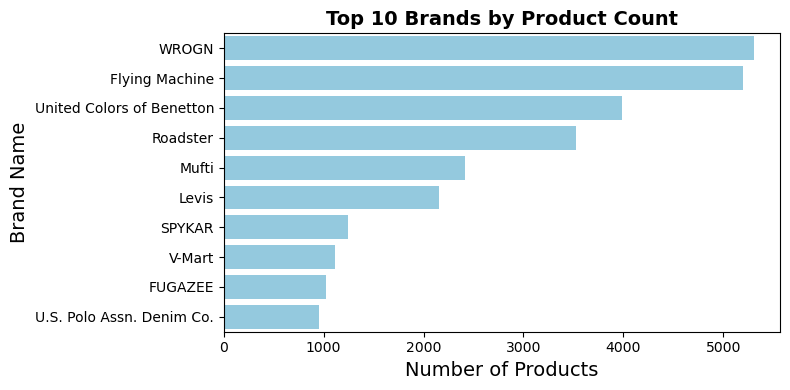

In [23]:
gb_brand = df.groupby('brand_name').agg({
    'price':'mean',
    'brand_name':'count'}).rename(columns={'price':'mean_price','brand_name':'count_items'}).reset_index()
top10_brands=gb_brand.sort_values('count_items',ascending=False).head(10)
plt.figure(figsize=(8,4))
sns.barplot(top10_brands,
            x='count_items',
            y= 'brand_name',
            color='skyblue')
plt.xlabel('Number of Products',fontsize=14)
plt.ylabel('Brand Name',fontsize=14)
plt.title('Top 10 Brands by Product Count', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

- histogram of net_discount (bins=20). Label axes and add a title.

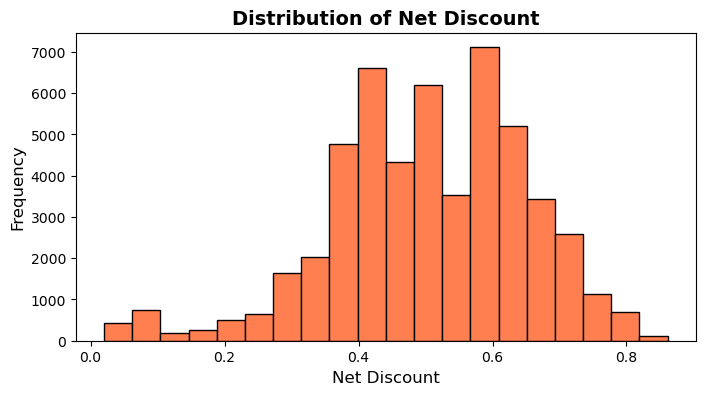

In [59]:
plt.figure(figsize=(8,4))
plt.hist(df['net_discount'],bins=20,color='coral',edgecolor='Black')
plt.xlabel('Net Discount',fontsize=12)
plt.ylabel('Frequency',fontsize=12)
plt.title('Distribution of Net Discount', fontsize=14, fontweight='bold')
plt.show()

- From seg_summary, draw a pie chart of count by segment with percentage labels.



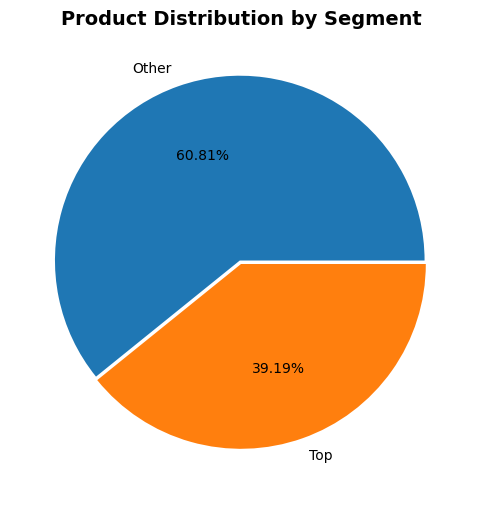

In [57]:
seg_segment=df.groupby('brand_segment').agg({
    'brand_name':'count'}).rename(columns={'brand_name':'Count'}).reset_index()
plt.figure(figsize=(6,6))
plt.pie(seg_segment['Count'],
       labels=seg_segment['brand_segment'],
       autopct='%1.2f%%',
       explode=(0.02,0))
plt.title('Product Distribution by Segment', fontsize=14, fontweight='bold')
plt.show()

- Build a line plot showing mean price per rating_band (order low→mid→high).`

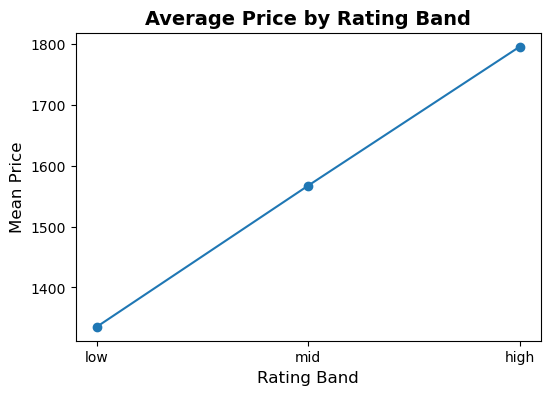

In [65]:
rating_price=df.groupby('rating_band',observed=True)['price'].mean().reset_index()
plt.figure(figsize=(6,4))
plt.plot(rating_price['rating_band'], rating_price['price'], marker='o')
plt.xlabel('Rating Band', fontsize=12)
plt.ylabel('Mean Price', fontsize=12)
plt.title('Average Price by Rating Band', fontsize=14, fontweight='bold')
plt.show()
            

- Plot directly from groupby: group by brand_name and plot mean ratings (top 10 brands by count). Use a horizontal bar chart.

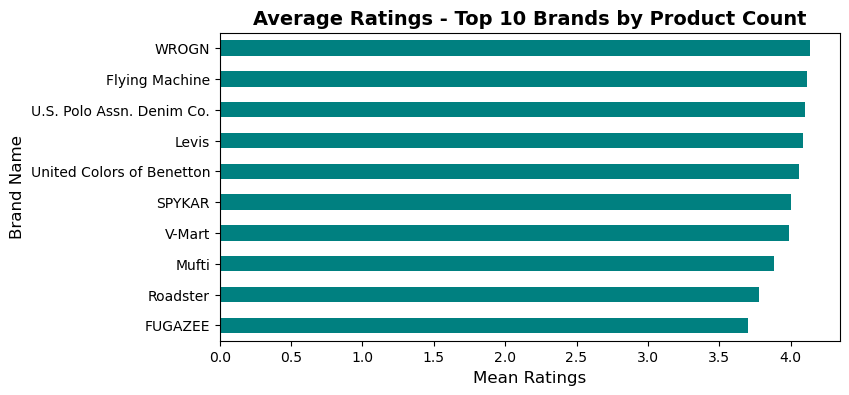

In [87]:
top10_brands=df['brand_name'].value_counts().head(10).index
df_top10=df[df['brand_name'].isin(top10_brands)]
plt.figure(figsize=(8,4))
df_top10.groupby('brand_name')['ratings'].mean().sort_values().plot(
    kind='barh',
    color='teal')
plt.xlabel('Mean Ratings',fontsize=12)
plt.ylabel('Brand Name',fontsize=12)
plt.title('Average Ratings - Top 10 Brands by Product Count', fontsize=14, fontweight='bold')
plt.show()
    

## matplotlib.pyplot Basics: plot(), bar(), scatter(); Styling & Subplots

- Using matplotlib directly, create a scatter of price vs ratings for 500 random samples (if available). Add labels/title and alpha for visibility.

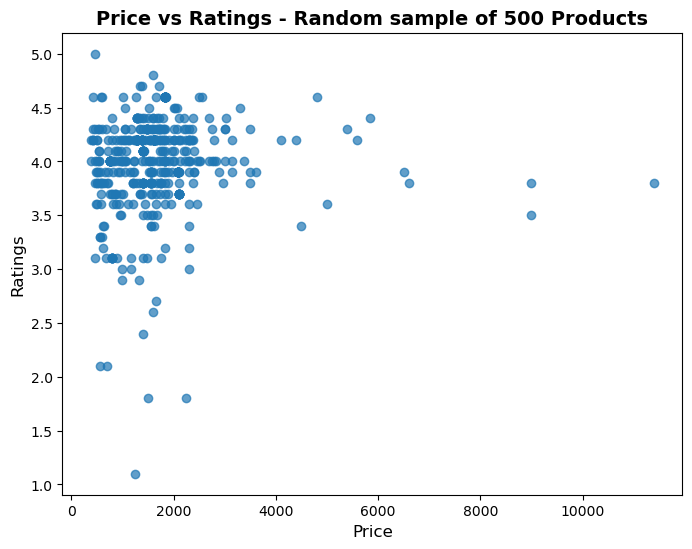

In [94]:
sample_size = min(500,len(df))
df_sample= df.sample(n=sample_size, random_state=42)
plt.figure(figsize=(8,6))
plt.scatter(
    df_sample['price'],
    df_sample['ratings'],
    alpha=0.7)
plt.xlabel('Price',fontsize=12)
plt.ylabel('Ratings',fontsize=12)
plt.title('Price vs Ratings - Random sample of 500 Products',fontsize=14,fontweight='bold')
plt.show()

- Create a bar chart with matplotlib: show counts of products per segment.

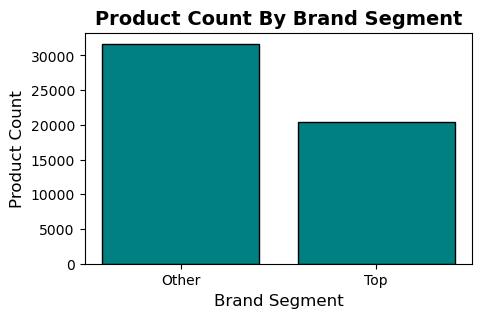

In [98]:
segment_counts = df['brand_segment'].value_counts()

# Step 2: Create bar chart
plt.figure(figsize=(5, 3))
plt.bar(segment_counts.index, segment_counts.values, color='teal', edgecolor='black')
plt.xlabel('Brand Segment',fontsize=12)
plt.ylabel('Product Count',fontsize=12)
plt.title('Product Count By Brand Segment',fontsize=14,fontweight='bold')
plt.show()

- Create a 1x2 subplot figure: (left) histogram of ratings; (right) histogram of price (use 20 bins). Add overall suptitle.

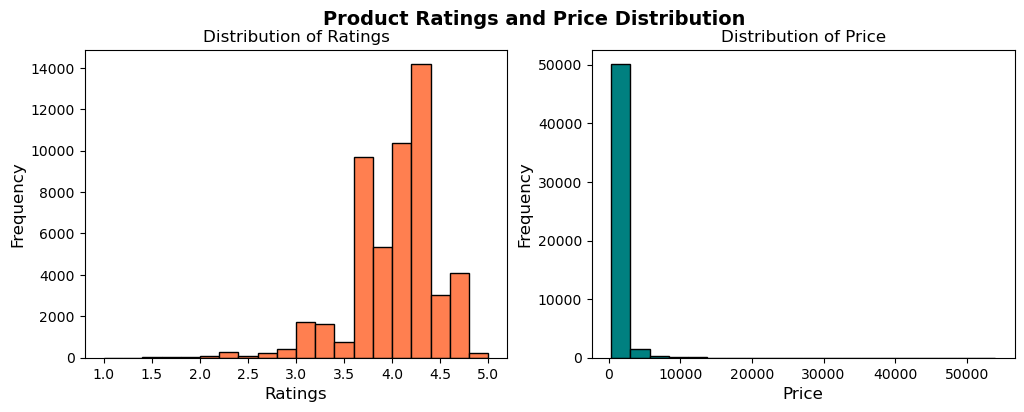

In [107]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].hist(df['ratings'], bins=20, color='coral', edgecolor='black')
axes[0].set_xlabel('Ratings', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].set_title('Distribution of Ratings', fontsize=12)
axes[1].hist(df['price'], bins=20, color='teal', edgecolor='black')
axes[1].set_xlabel('Price', fontsize=12)
axes[1].set_ylabel('Frequency', fontsize=12)
axes[1].set_title('Distribution of Price', fontsize=12)
fig.suptitle('Product Ratings and Price Distribution', fontsize=14, fontweight='bold')
plt.show()

## Save Cleaned Data & Figures

In [108]:
df.to_csv("C:\\Users\\user\\Downloads\\myntra_cleaned.csv")